In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import plotly.express as px

from sql_server import engine

from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss

Confusion Matrix plot function.

In [2]:
def plot_confusion_matrix(y, y_predict):
    LABELS = ['Others', 'Top Points']
    conf_matrix = confusion_matrix(y, y_predict)

    plt.figure()
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

### Load Data

In [3]:
df = pd.read_sql_query('''\
                       select * from ml_data_3
                       ''', engine)

In [4]:
df.head()

,gameweek,web_name,first_name,position,team,event_points,in_dreamteam,gameweek_goals,gameweek_assists,gameweek_saves,gameweek_cleansheet,home,away,team_strength_diff,own_goals_per_90,penalties_saved_per_90,penalties_missed_per_90,points_per_game,yellow_cards_per_90,red_cards_per_90,influence,creativity,threat,goals_scored_per_90,assists_per_90,saves_per_90,goals_conceded_per_90,starts_per_90,clean_sheets_per_90
0,23,Gray,Archie,Midfielder,Spurs,2,False,0,0,0,0,1,0,65,0.114943,0.0,0.0,1.5,0.000000,0.0,142.4,13.9,7.0,0.000000,0.000000,0.0,2.07,0.92,0.11
1,23,Johnson,Brennan,Midfielder,Spurs,0,False,0,0,0,0,1,0,65,0.000000,0.0,0.0,4.2,0.181208,0.0,380.2,215.7,614.0,0.422819,0.241611,0.0,1.27,0.97,0.12
2,23,Davies,Ben,Defender,Spurs,1,False,0,0,0,0,1,0,65,0.000000,0.0,0.0,2.2,0.250000,0.0,95.6,7.2,4.0,0.000000,0.000000,0.0,1.25,1.00,0.25
3,23,Dragusin,Radu,Defender,Spurs,1,False,0,0,0,0,1,0,65,0.000000,0.0,0.0,1.5,0.077586,0.0,229.6,32.8,39.0,0.000000,0.000000,0.0,2.09,1.01,0.16
4,23,Bentancur,Rodrigo,Midfielder,Spurs,2,False,0,0,0,0,1,0,65,0.000000,0.0,0.0,2.2,0.656934,0.0,149.4,75.9,86.0,0.262774,0.000000,0.0,1.58,1.18,0.13


In [5]:
dummies = pd.get_dummies(df.position)
df = pd.concat([df, dummies], axis='columns')

In [6]:
df.shape

(1576, 33)

In [7]:
df.dtypes

gameweek                     int64
web_name                    object
first_name                  object
position                    object
team                        object
event_points                 int64
in_dreamteam                  bool
gameweek_goals               int64
gameweek_assists             int64
gameweek_saves               int64
gameweek_cleansheet          int64
home                         int64
away                         int64
team_strength_diff           int64
own_goals_per_90           float64
penalties_saved_per_90     float64
penalties_missed_per_90    float64
points_per_game             object
yellow_cards_per_90        float64
red_cards_per_90           float64
influence                   object
creativity                  object
threat                      object
goals_scored_per_90        float64
assists_per_90             float64
saves_per_90               float64
goals_conceded_per_90      float64
starts_per_90              float64
clean_sheets_per_90 

In [8]:
df[['in_dreamteam', 'Defender', 'Forward', 'Goalkeeper', 'Midfielder']] = df[['in_dreamteam', 'Defender', 'Forward', 'Goalkeeper', 'Midfielder']].astype(int)
df[['points_per_game', 'influence', 'creativity', 'threat']] = df[['points_per_game', 'influence', 'creativity', 'threat']].astype(float)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gameweek,1576.0,24.480330,1.195598,23.0,23.000000,24.000000,26.000000,27.000000
event_points,1576.0,1.831853,2.838560,-3.0,0.000000,1.000000,2.000000,21.000000
in_dreamteam,1576.0,0.024112,0.153445,0.0,0.000000,0.000000,0.000000,1.000000
gameweek_goals,1576.0,0.064721,0.288838,0.0,0.000000,0.000000,0.000000,3.000000
gameweek_assists,1576.0,0.057107,0.267689,0.0,0.000000,0.000000,0.000000,3.000000
gameweek_saves,1576.0,0.135787,0.735901,0.0,0.000000,0.000000,0.000000,8.000000
gameweek_cleansheet,1576.0,0.134518,0.341316,0.0,0.000000,0.000000,0.000000,1.000000
home,1576.0,0.496193,0.500144,0.0,0.000000,0.000000,1.000000,1.000000
away,1576.0,0.503807,0.500144,0.0,0.000000,1.000000,1.000000,1.000000
team_strength_diff,1576.0,-4.365482,111.601802,-280.0,-70.000000,-5.000000,70.000000,280.000000


<Axes: xlabel='goals_conceded_per_90'>

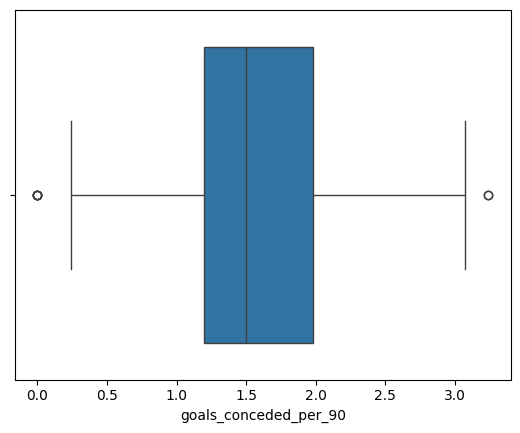

In [10]:
sns.boxplot(df[df['goals_conceded_per_90'] < 3.3], x='goals_conceded_per_90')

In [11]:
df = df[df['goals_conceded_per_90'] < 3.3]

In [12]:
df.isnull().sum()

gameweek                   0
web_name                   0
first_name                 0
position                   0
team                       0
event_points               0
in_dreamteam               0
gameweek_goals             0
gameweek_assists           0
gameweek_saves             0
gameweek_cleansheet        0
home                       0
away                       0
team_strength_diff         0
own_goals_per_90           0
penalties_saved_per_90     0
penalties_missed_per_90    0
points_per_game            0
yellow_cards_per_90        0
red_cards_per_90           0
influence                  0
creativity                 0
threat                     0
goals_scored_per_90        0
assists_per_90             0
saves_per_90               0
goals_conceded_per_90      0
starts_per_90              0
clean_sheets_per_90        0
Defender                   0
Forward                    0
Goalkeeper                 0
Midfielder                 0
dtype: int64

In [13]:
df = df.dropna()

C:\Users\kakaf\AppData\Local\Temp\ipykernel_5580\1989196770.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['false', 'true'])


[Text(0, 0, 'false'), Text(1, 0, 'true')]

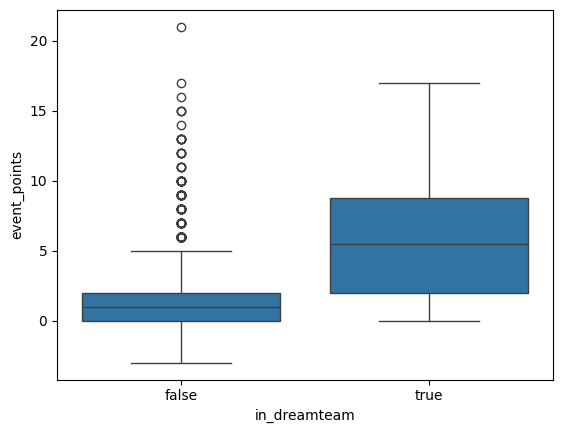

In [14]:
g = sns.boxplot(x='in_dreamteam', y='event_points', data=df)
g.set_xticklabels(['false', 'true'])

In [15]:
df.columns

Index(['gameweek', 'web_name', 'first_name', 'position', 'team',
       'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists',
       'gameweek_saves', 'gameweek_cleansheet', 'home', 'away',
       'team_strength_diff', 'own_goals_per_90', 'penalties_saved_per_90',
       'penalties_missed_per_90', 'points_per_game', 'yellow_cards_per_90',
       'red_cards_per_90', 'influence', 'creativity', 'threat',
       'goals_scored_per_90', 'assists_per_90', 'saves_per_90',
       'goals_conceded_per_90', 'starts_per_90', 'clean_sheets_per_90',
       'Defender', 'Forward', 'Goalkeeper', 'Midfielder'],
      dtype='object')

In [16]:
def pred_logreg_cv(data, position):
    print('Logistic Regression: ')
    data = data[data[position] == 1]
    top_point = data['event_points'].quantile(0.9)
    data = data.assign(top_points=[1 if x > top_point else 0 for x in data['event_points']])

    X = data.drop(['gameweek', 'web_name', 'first_name', 'position', 'team', 
        'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists', 'gameweek_saves', 'gameweek_cleansheet', 'top_points'], axis=1)

    y = data['top_points'].to_numpy()

    transform = preprocessing.StandardScaler()
    X = transform.fit(X).transform(X.astype(float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    parameters = {
        'C':[0.01, 0.1, 1],
        'penalty':['l2'],
        'solver':['lbfgs']
    }

    lr = LogisticRegression()
    logreg_cv = GridSearchCV(lr, parameters, cv=10).fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
    print("accuracy :", logreg_cv.best_score_)
    print('score :', logreg_cv.score(X_test, y_test))

    yhat = logreg_cv.predict(X_test)
    plot_confusion_matrix(y_test, yhat)

    print(classification_report(y_test, yhat))

    joblib.dump(logreg_cv.best_estimator_, position+'_logreg.joblib', compress=1)

    return logreg_cv.best_score_
    print('==================================================')

def pred_tree_cv(data, position):
    print('Decision Tree: ')
    data = data[data[position] == 1]
    top_point = data['event_points'].quantile(0.9)
    data = data.assign(top_points=[1 if x > top_point else 0 for x in data['event_points']])

    X = data.drop(['gameweek', 'web_name', 'first_name', 'position', 'team', 
        'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists', 'gameweek_saves', 'gameweek_cleansheet', 'top_points'], axis=1)

    y = data['top_points'].to_numpy()

    transform = preprocessing.StandardScaler()
    X = transform.fit(X).transform(X.astype(float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    parameters = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [2*n for n in range(1,10)],
        'max_features': ['log2', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]
    }

    tree = DecisionTreeClassifier()
    tree_cv = GridSearchCV(tree, parameters, cv=10).fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", tree_cv.best_params_)
    print("accuracy :", tree_cv.best_score_)
    print('score :', tree_cv.score(X_test, y_test))

    yhat = tree_cv.predict(X_test)
    plot_confusion_matrix(y_test, yhat)

    print(classification_report(y_test, yhat))

    joblib.dump(tree_cv.best_estimator_, position+'_tree.joblib', compress=1)

    return tree_cv.best_score_
    print('==================================================')

def pred_knn_cv(data, position):
    print('KNN: ')
    data = data[data[position] == 1]
    top_point = data['event_points'].quantile(0.9)
    data = data.assign(top_points=[1 if x > top_point else 0 for x in data['event_points']])

    X = data.drop(['gameweek', 'web_name', 'first_name', 'position', 'team', 
        'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists', 'gameweek_saves', 'gameweek_cleansheet', 'top_points'], axis=1)

    y = data['top_points'].to_numpy()

    transform = preprocessing.StandardScaler()
    X = transform.fit(X).transform(X.astype(float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    parameters = {
        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1,2]
    }

    KNN = KNeighborsClassifier()
    knn_cv = GridSearchCV(KNN, parameters, cv=10).fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", knn_cv.best_params_)
    print("accuracy :", knn_cv.best_score_)
    print('score :', knn_cv.score(X_test, y_test))

    yhat = knn_cv.predict(X_test)
    plot_confusion_matrix(y_test, yhat)

    print(classification_report(y_test, yhat))

    joblib.dump(knn_cv, position+'_knn.joblib', compress=1)

    return knn_cv.best_score_
    print('==================================================')

def pred_svc_cv(data, position):
    print('SVM: ')
    data = data[data[position] == 1]
    top_point = data['event_points'].quantile(0.9)
    data = data.assign(top_points=[1 if x > top_point else 0 for x in data['event_points']])

    X = data.drop(['gameweek', 'web_name', 'first_name', 'position', 'team', 
        'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists', 'gameweek_saves', 'gameweek_cleansheet', 'top_points'], axis=1)

    y = data['top_points'].to_numpy()

    transform = preprocessing.StandardScaler()
    X = transform.fit(X).transform(X.astype(float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    parameters = {
        'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid'),
        'C': np.logspace(-3, 3, 5),
        'gamma':np.logspace(-3, 3, 5)
    }

    svm = SVC()
    svm_cv = GridSearchCV(svm, parameters, cv=2).fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", svm_cv.best_params_)
    print("accuracy :", svm_cv.best_score_)
    print('score :', svm_cv.score(X_test, y_test))

    yhat = svm_cv.predict(X_test)
    plot_confusion_matrix(y_test, yhat)

    print(classification_report(y_test, yhat))

    joblib.dump(svm_cv, position+'_svc.joblib', compress=1)

    return svm_cv.best_score_
    print('==================================================')

In [17]:
def model_by_position(position):
    logreg_score = pred_logreg_cv(df, position)
    svm_score = pred_svc_cv(df, position)
    tree_score = pred_tree_cv(df, position)
    knn_score = pred_knn_cv(df, position)

    dict = [
        {'Model': 'logreg_cv', 'Score': logreg_score},
        {'Model': 'svm_cv', 'Score': svm_score},
        {'Model': 'tree_cv', 'Score': tree_score},
        {'Model': 'knn_cv', 'Score': knn_score}
    ]

    df_a = pd.DataFrame(dict)

    fig = px.bar(
        df_a, x='Model', y='Score',
        text_auto='.5f',
        title=position+' Model Results'
    )
    fig.show()

Logistic Regression: 
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.9
score : 0.78125


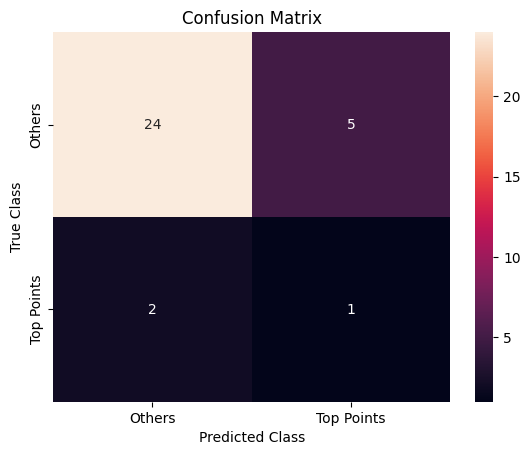

              precision    recall  f1-score   support

           0       0.92      0.83      0.87        29
           1       0.17      0.33      0.22         3

    accuracy                           0.78        32
   macro avg       0.54      0.58      0.55        32
weighted avg       0.85      0.78      0.81        32

SVM: 
tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'gamma': 0.001, 'kernel': 'linear'}
accuracy : 0.9434782608695652
score : 0.78125


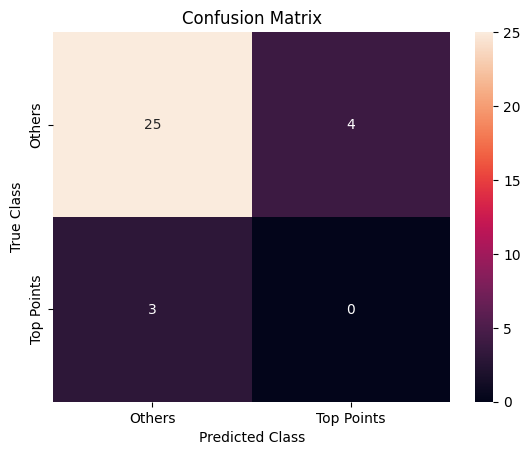

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.00      0.00      0.00         3

    accuracy                           0.78        32
   macro avg       0.45      0.43      0.44        32
weighted avg       0.81      0.78      0.79        32

Decision Tree: 
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9217391304347826
score : 0.875


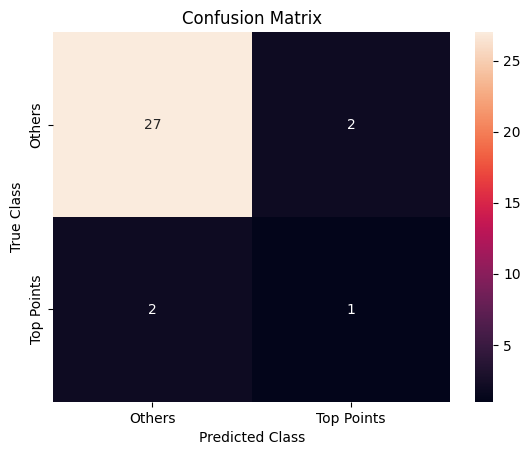

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        29
           1       0.33      0.33      0.33         3

    accuracy                           0.88        32
   macro avg       0.63      0.63      0.63        32
weighted avg       0.88      0.88      0.88        32

KNN: 
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.9434782608695652
score : 0.78125


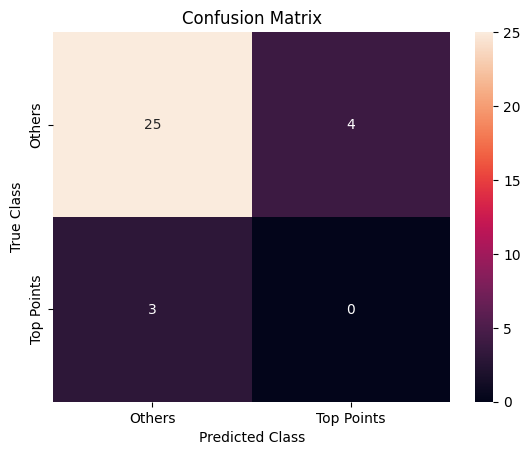

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.00      0.00      0.00         3

    accuracy                           0.78        32
   macro avg       0.45      0.43      0.44        32
weighted avg       0.81      0.78      0.79        32



In [18]:
model_by_position('Forward')

Logistic Regression: 
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.6877240477968634
score : 0.6827586206896552


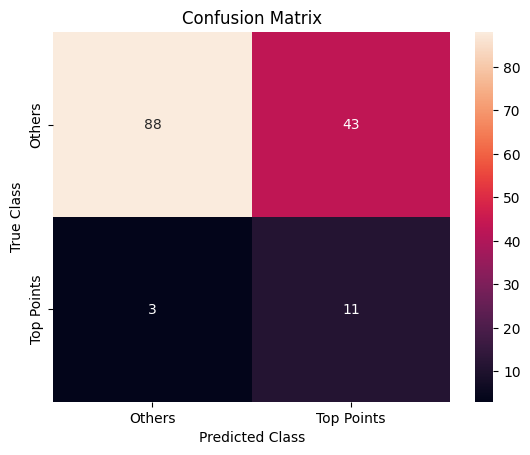

              precision    recall  f1-score   support

           0       0.97      0.67      0.79       131
           1       0.20      0.79      0.32        14

    accuracy                           0.68       145
   macro avg       0.59      0.73      0.56       145
weighted avg       0.89      0.68      0.75       145

SVM: 
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
accuracy : 0.9267822736030829
score : 0.8827586206896552


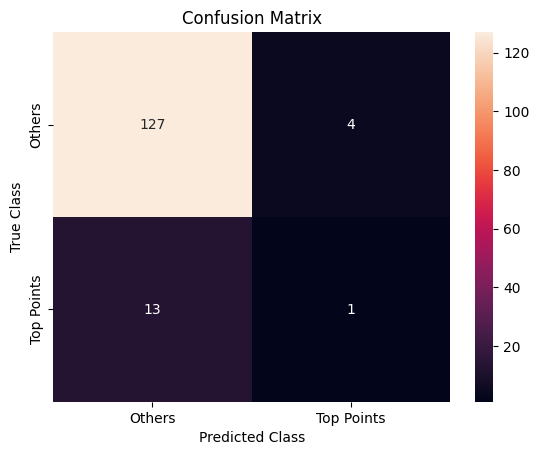

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       131
           1       0.20      0.07      0.11        14

    accuracy                           0.88       145
   macro avg       0.55      0.52      0.52       145
weighted avg       0.84      0.88      0.86       145

Decision Tree: 


d:\01topan\01goals\goalsenv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8631908140403286
score : 0.7517241379310344


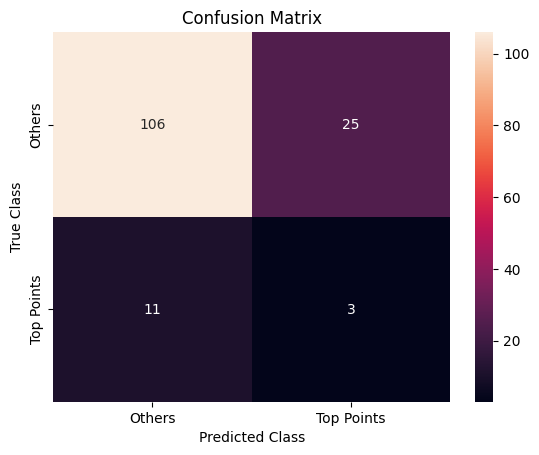

              precision    recall  f1-score   support

           0       0.91      0.81      0.85       131
           1       0.11      0.21      0.14        14

    accuracy                           0.75       145
   macro avg       0.51      0.51      0.50       145
weighted avg       0.83      0.75      0.79       145

KNN: 
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.9228902165795372
score : 0.8068965517241379


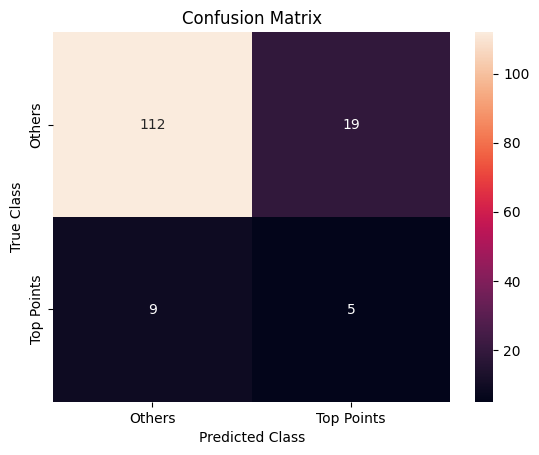

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       131
           1       0.21      0.36      0.26        14

    accuracy                           0.81       145
   macro avg       0.57      0.61      0.58       145
weighted avg       0.86      0.81      0.83       145



In [19]:
model_by_position('Midfielder')

Logistic Regression: 
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7621951219512195
score : 0.8181818181818182


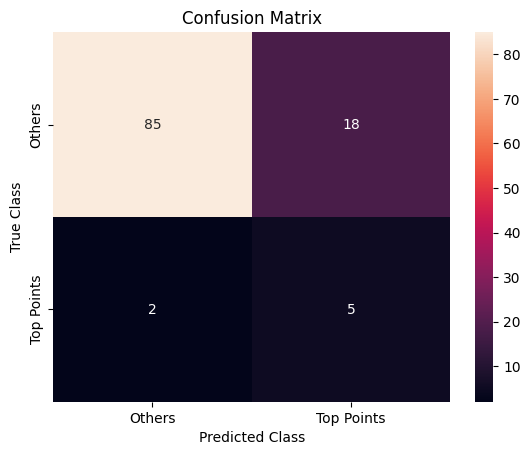

              precision    recall  f1-score   support

           0       0.98      0.83      0.89       103
           1       0.22      0.71      0.33         7

    accuracy                           0.82       110
   macro avg       0.60      0.77      0.61       110
weighted avg       0.93      0.82      0.86       110

SVM: 
tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'gamma': 1.0, 'kernel': 'rbf'}
accuracy : 0.95
score : 0.9363636363636364


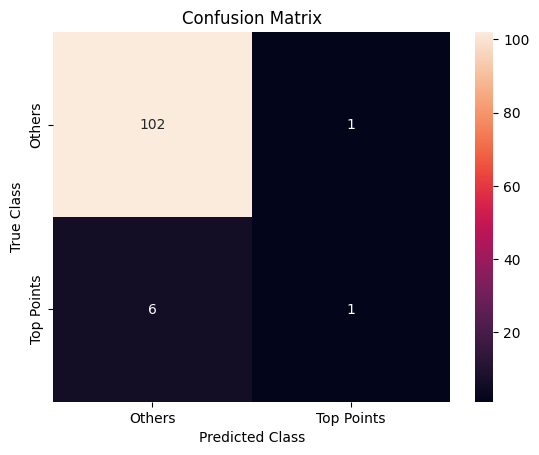

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       103
           1       0.50      0.14      0.22         7

    accuracy                           0.94       110
   macro avg       0.72      0.57      0.59       110
weighted avg       0.92      0.94      0.92       110

Decision Tree: 


d:\01topan\01goals\goalsenv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9195121951219513
score : 0.8454545454545455


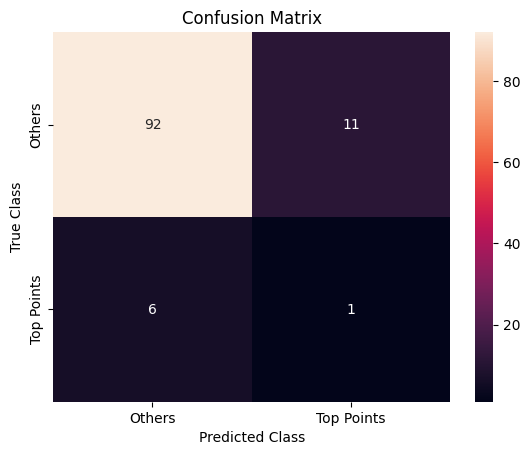

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       103
           1       0.08      0.14      0.11         7

    accuracy                           0.85       110
   macro avg       0.51      0.52      0.51       110
weighted avg       0.88      0.85      0.86       110

KNN: 
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.9670731707317073
score : 0.8818181818181818


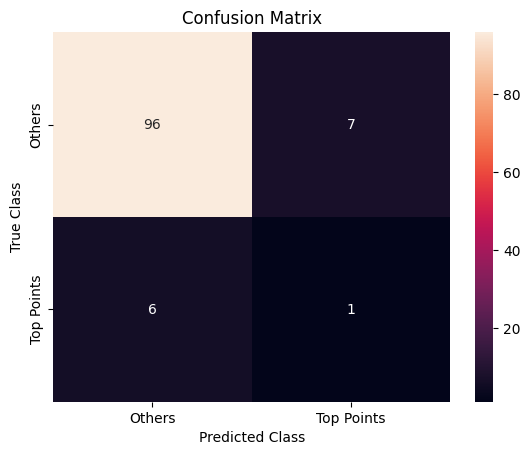

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       103
           1       0.12      0.14      0.13         7

    accuracy                           0.88       110
   macro avg       0.53      0.54      0.53       110
weighted avg       0.89      0.88      0.89       110



In [20]:
model_by_position('Defender')

Logistic Regression: 
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.9099415204678362
score : 0.8846153846153846


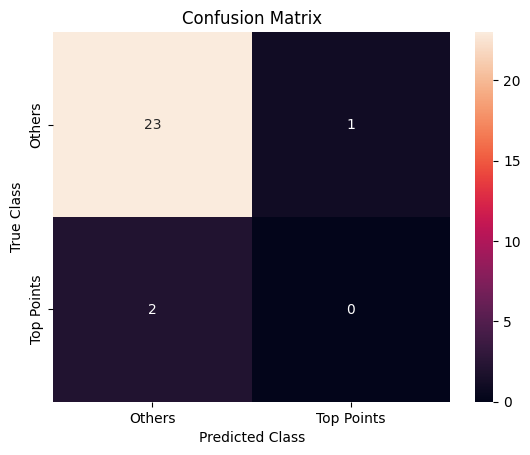

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        24
           1       0.00      0.00      0.00         2

    accuracy                           0.88        26
   macro avg       0.46      0.48      0.47        26
weighted avg       0.85      0.88      0.87        26

SVM: 
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
accuracy : 0.9301075268817205
score : 0.9230769230769231


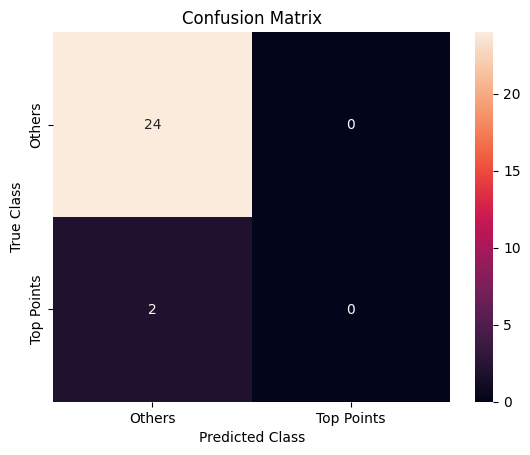

d:\01topan\01goals\goalsenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\01topan\01goals\goalsenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\01topan\01goals\goalsenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       0.00      0.00      0.00         2

    accuracy                           0.92        26
   macro avg       0.46      0.50      0.48        26
weighted avg       0.85      0.92      0.89        26

Decision Tree: 
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9359649122807017
score : 0.9230769230769231


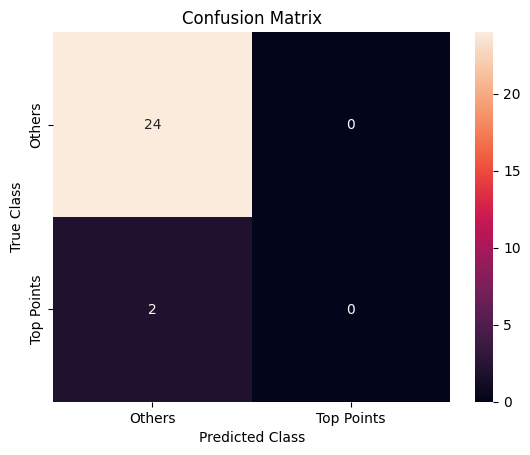

d:\01topan\01goals\goalsenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\01topan\01goals\goalsenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\01topan\01goals\goalsenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       0.00      0.00      0.00         2

    accuracy                           0.92        26
   macro avg       0.46      0.50      0.48        26
weighted avg       0.85      0.92      0.89        26

KNN: 
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.9570175438596491
score : 0.8846153846153846


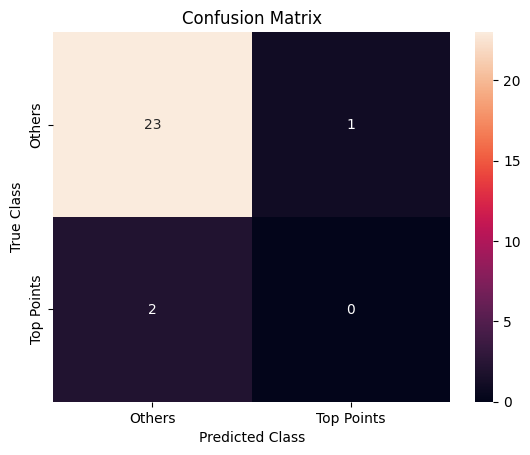

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        24
           1       0.00      0.00      0.00         2

    accuracy                           0.88        26
   macro avg       0.46      0.48      0.47        26
weighted avg       0.85      0.88      0.87        26



In [21]:
model_by_position('Goalkeeper')